In [1]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import shap

In [2]:
stats = pd.read_csv("Data_Stats.csv", index_col=0)

In [3]:
del stats['_ID_NEW']
del stats['NTm']
del stats['Team']
del stats['PTS_R']
del stats['AST_R']
del stats['STL_R']
del stats['BLK_R']
del stats['3P_R']
del stats['Point_Contribution_PG'] 

In [4]:
stats2 = stats.copy()
del stats2['Level_of_Impact']
del stats2['Quality_of_Impact']
del stats2['Wins_Contribution']
del stats2['Total_Stats']
train = stats2[~(stats2["Year"] == 2021)]
test = stats2[stats2["Year"] == 2021]

In [5]:
predictors = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Team W', 'Team L',
       'Team WL', 'Team GB', 'Team PS G', 'Team PA G', 'Team P Diff', 'NPos',
        'per', 'ts_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct',
       'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct',
       'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm',
       'bpm', 'vorp', 'mov', 'mov_adj']

In [6]:
#Methods
def backtest(stats2, model, years, predictors):
    aps = []
    all_predictions = []
    for year in years:
        train = stats2[stats2["Year"] < year]
        test = stats2[stats2["Year"] == year]
        model.fit(train[predictors],train["Share pc"])
        predictions1 = model.predict(test[predictors])
        predictions1 = pd.DataFrame(predictions1, columns=["predictions1"], index=test.index)
        combination1 = pd.concat([test[["Player", "Share pc", "Year"]], predictions1], axis=1)
        combination1 = add_ranks(combination1)
        all_predictions.append(combination1)
        aps.append(find_ap(combination1))
    return sum(aps) / len(aps), aps, pd.concat(all_predictions)

In [7]:
def add_ranks(predictions1):
    predictions1 = predictions1.sort_values("predictions1", ascending=False)
    predictions1["Predicted_Rk"] = list(range(1,predictions1.shape[0]+1))
    predictions1 = predictions1.sort_values("Share pc", ascending=False)
    predictions1["Rk"] = list(range(1,predictions1.shape[0]+1))
    predictions1["Diff"] = (predictions1["Rk"] - predictions1["Predicted_Rk"])
    return predictions1

In [8]:
def find_ap(combination1):
    actual = combination1.sort_values("Share pc", ascending=False).head(5)
    predicted = combination1.sort_values("predictions1", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index,row in predicted.iterrows():
        if row["Player"] in actual["Player"].values:
            found += 1
            ps.append(found / seen)
        seen += 1

    return sum(ps) / len(ps)

In [9]:
def calculate_ml_scores(df):
    X = df.copy()
    y = X["Share pc"]

    X.drop('Share pc', axis=1, inplace=True)

    # Label encoding for categoricals
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return X, y, mi_scores

In [10]:
def plot_mi_scores(scores, figsize):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(width, scores)
    
    for index, value in enumerate(scores):
        plt.text(value +0.005 , index, str(round(value,2)))
    
    plt.yticks(width, ticks)    
    plt.title("Mutual Information Scores")

In [20]:
stats2[predictors].shape

(14697, 56)

In [21]:
years = list(range(1991,2023))

In [22]:
#Regression Models Round 1
#Ridge
reg = Ridge(alpha=.1)

In [23]:
reg.fit(train[predictors],train["Share pc"])

Ridge(alpha=0.1)

In [24]:
mean_ap_ridge_1, aps_ridge_1, all_predictions_ridge_1 = backtest(stats2, reg, years[5:], predictors)

In [25]:
mean_ap_ridge_1

0.7766264771044185

In [26]:
mean_squared_error(all_predictions_ridge_1["Share pc"], all_predictions_ridge_1["predictions1"])

0.0024934773712691344

In [27]:
mean_absolute_error(all_predictions_ridge_1["Share pc"], all_predictions_ridge_1["predictions1"])

0.020191489107436414

In [28]:
#Random FOrrest
rf = RandomForestRegressor(n_estimators=50, random_state=1, min_samples_split=5)

In [29]:
mean_ap_rf_1, aps_rf_1, all_predictions_rf_1 = backtest(stats2, rf, years[5:], predictors)

In [30]:
mean_ap_rf_1

0.8144363963318209

In [31]:
mean_squared_error(all_predictions_rf_1["Share pc"], all_predictions_rf_1["predictions1"])

0.001127410404135947

In [32]:
mean_absolute_error(all_predictions_rf_1["Share pc"], all_predictions_rf_1["predictions1"])

0.004165058667561574

In [33]:
#Linear Regression
lr = LinearRegression()

In [34]:
mean_ap_lr_1, aps_lr_1, all_predictions_lr_1 = backtest(stats2, lr, years[5:], predictors)

In [35]:
mean_ap_lr_1

0.7740198160337052

In [36]:
mean_squared_error(all_predictions_lr_1["Share pc"], all_predictions_lr_1["predictions1"])

0.002499633645903594

In [37]:
mean_absolute_error(all_predictions_lr_1["Share pc"], all_predictions_lr_1["predictions1"])

0.02025638542826275

In [38]:
#Variable Selection 1
to_drop_mi = ['Player', 'Pos', 'Tm','Share Pts Won', 'Share Pts Max','Rank_MVP','ws_per_48','obpm','Year']

In [39]:
master_table_mi = stats2.copy()
master_table_mi.drop(to_drop_mi, axis=1, inplace=True)

In [40]:
X, y, mi_scores = calculate_ml_scores(df=master_table_mi)

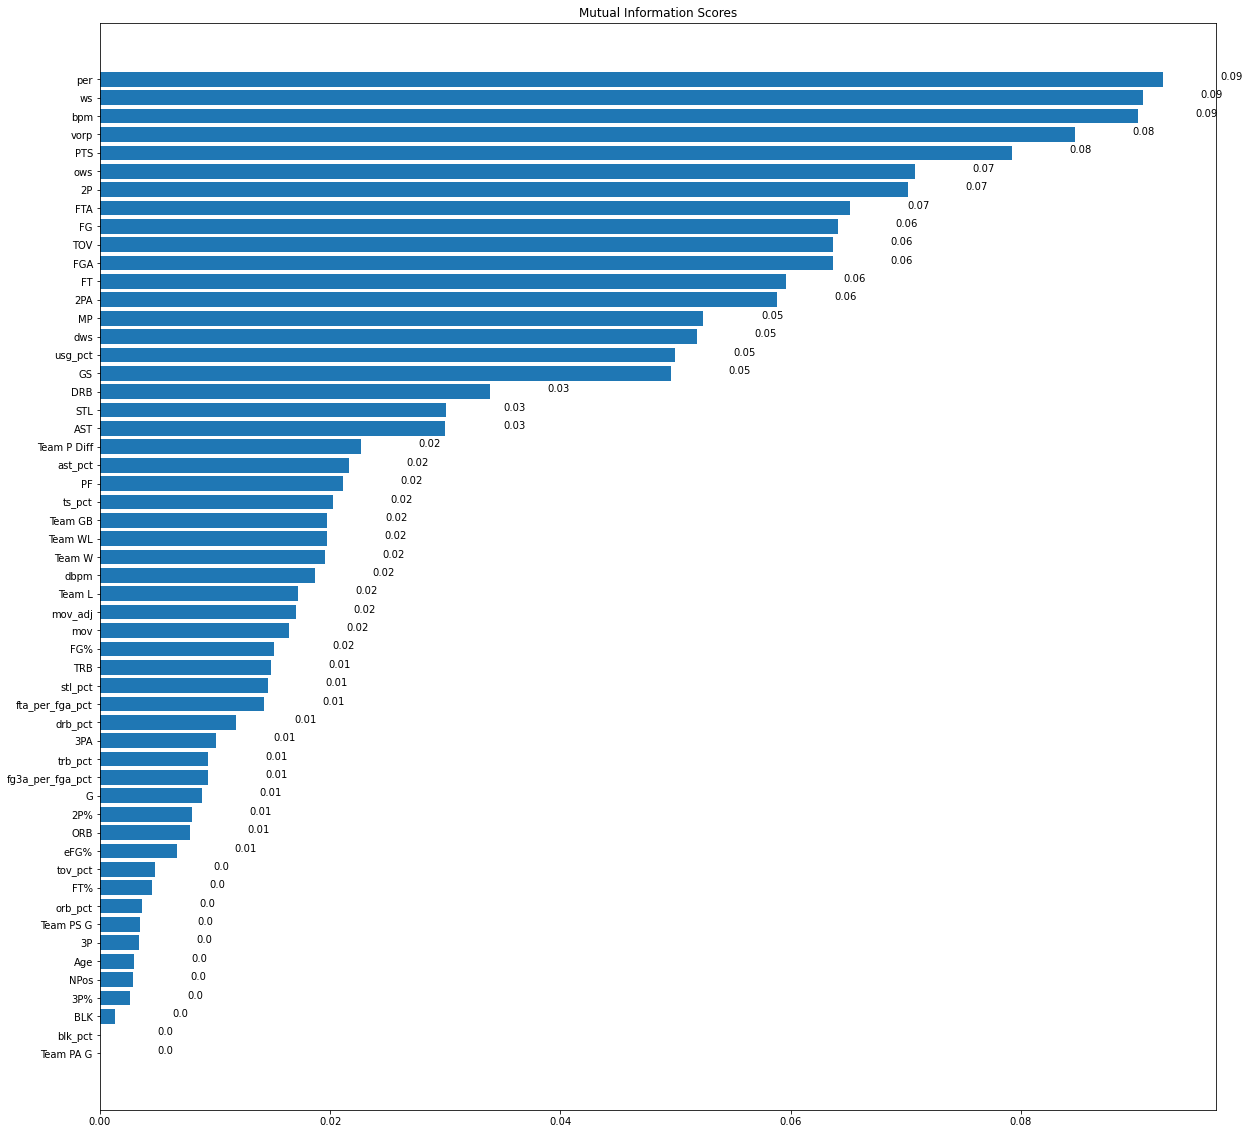

In [41]:
plot_mi_scores(mi_scores, figsize=(20,20))

In [42]:
##Regression Models Round 2
predictors2 = ["vorp","bpm","per","FG","FTA","ws","PTS","ows","2P","2PA","FT","MP","FGA","TOV", "dws", "usg_pct"]

In [43]:
stats2[predictors2].shape

(14697, 16)

In [44]:
mean_ap_ridge_2, aps_ridge_2, all_predictions_ridge_2 = backtest(stats2, reg, years[5:], predictors2)
mean_ap_rf_2, aps_rf_2, all_predictions_rf_2 = backtest(stats2, rf, years[5:], predictors2)
mean_ap_lr_2, aps_lr_2, all_predictions_lr_2 = backtest(stats2, lr, years[5:], predictors2)

In [45]:
mean_ap_ridge_2,mean_ap_rf_2,mean_ap_lr_2

(0.8006559741062664, 0.7840736886570219, 0.8006529949366206)

In [46]:
mean_squared_error(all_predictions_ridge_2["Share pc"], all_predictions_ridge_2["predictions1"]),mean_squared_error(all_predictions_rf_2["Share pc"], all_predictions_rf_2["predictions1"]),mean_squared_error(all_predictions_lr_2["Share pc"], all_predictions_lr_2["predictions1"])

(0.0025292244609156876, 0.0012799958051701848, 0.0025292926258901676)

In [47]:
mean_absolute_error(all_predictions_ridge_2["Share pc"], all_predictions_ridge_2["predictions1"]),mean_absolute_error(all_predictions_rf_2["Share pc"], all_predictions_rf_2["predictions1"]),mean_absolute_error(all_predictions_lr_2["Share pc"], all_predictions_lr_2["predictions1"])

(0.020162463849287143, 0.004489031104170639, 0.020163782894665545)

In [48]:
#Variable Selection 2
master_table_mi = stats.copy()

In [49]:
master_table_mi.drop(to_drop_mi, axis=1, inplace=True)

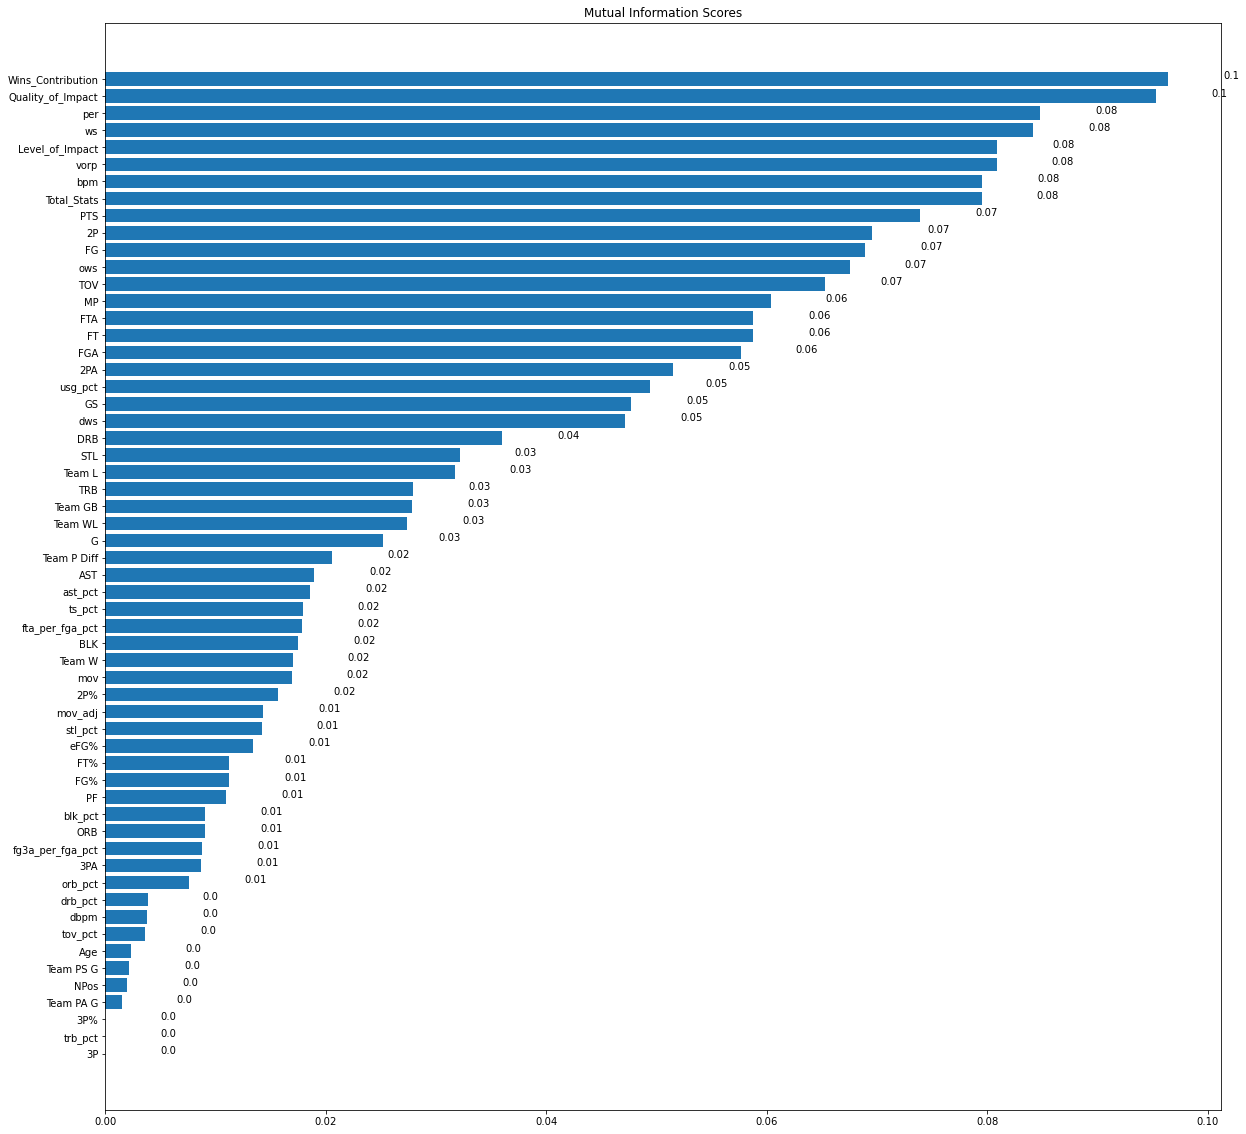

In [50]:
X, y, mi_scores = calculate_ml_scores(df=master_table_mi)
plot_mi_scores(mi_scores, figsize=(20,20))

In [51]:
#Regression Models Round 3
predictors3 = ["vorp","bpm","per","FG","FTA","ws","PTS","ows","2P","2PA","FT","MP","FGA","TOV", "dws", "usg_pct", "Level_of_Impact","Quality_of_Impact","Wins_Contribution","Total_Stats"]

In [52]:
stats[predictors3].shape

(14697, 20)

In [53]:
mean_ap_ridge_3, aps_ridge_3, all_predictions_ridge_3 = backtest(stats, reg, years[5:], predictors3)
mean_ap_rf_3, aps_rf_3, all_predictions_rf_3 = backtest(stats, rf, years[5:], predictors3)
mean_ap_lr_3, aps_lr_3, all_predictions_lr_3 = backtest(stats, lr, years[5:], predictors3)

In [54]:
mean_ap_ridge_3, mean_ap_rf_3, mean_ap_lr_3

(0.8208045633046246, 0.8017561477706406, 0.8208047494203886)

In [55]:
mean_squared_error(all_predictions_ridge_3["Share pc"], all_predictions_ridge_3["predictions1"]),mean_squared_error(all_predictions_rf_3["Share pc"], all_predictions_rf_3["predictions1"]),mean_squared_error(all_predictions_lr_3["Share pc"], all_predictions_lr_3["predictions1"])

(0.0015989772503640577, 0.0010743650491402117, 0.0015990217786723136)

In [56]:
mean_absolute_error(all_predictions_ridge_3["Share pc"], all_predictions_ridge_3["predictions1"]),mean_absolute_error(all_predictions_rf_3["Share pc"], all_predictions_rf_3["predictions1"]),mean_absolute_error(all_predictions_lr_3["Share pc"], all_predictions_lr_3["predictions1"])

(0.0155588359209352, 0.004039945541896123, 0.01555961454620801)

In [57]:
all_predictions_ridge_1.to_csv("all_predictions_ridge_1.csv")
all_predictions_ridge_2.to_csv("all_predictions_ridge_2.csv")
all_predictions_ridge_3.to_csv("all_predictions_ridge_3.csv")
all_predictions_rf_1.to_csv("all_predictions_rf_1.csv")
all_predictions_rf_2.to_csv("all_predictions_rf_2.csv")
all_predictions_rf_3.to_csv("all_predictions_rf_3.csv")
all_predictions_lr_1.to_csv("all_predictions_lr_1.csv")
all_predictions_lr_2.to_csv("all_predictions_lr_2.csv")
all_predictions_lr_3.to_csv("all_predictions_lr_3.csv")

In [59]:
#Regression Models Round 4
#Ridge Tuning
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
reg0 = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')

In [60]:
reg0.fit(train[predictors],train["Share pc"])

RidgeCV(alphas=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
        scoring='neg_mean_absolute_error')

In [61]:
print(reg0.alpha_) # how much the coef shrinks

0.99


In [62]:
reg = Ridge(alpha=reg0.alpha_)

In [63]:
reg.fit(train[predictors],train["Share pc"])#use predictors to predict Share

Ridge(alpha=0.99)

In [64]:
mean_ap_ridge_4, aps_ridge_4, all_predictions_ridge_4 = backtest(stats, reg, years[5:], predictors3)


In [65]:
mean_ap_ridge_4

0.8208049053592418

In [66]:
all_predictions_ridge_4

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
10962,Michael Jordan,0.986,1996,0.885454,1,1,0
10261,David Robinson,0.508,1996,0.489956,2,2,0
7645,Anfernee Hardaway,0.319,1996,0.269811,4,3,-1
5197,Hakeem Olajuwon,0.211,1996,0.207774,6,4,-2
10965,Scottie Pippen,0.200,1996,0.245368,5,5,0
...,...,...,...,...,...,...,...
8239,Jemerrio Jones,0.000,2022,0.007344,209,601,392
11879,Greg Monroe,0.000,2022,0.007338,210,602,392
1860,Jahmi'us Ramsey,0.000,2022,0.007307,211,603,392


In [ ]:
#Random Forrest Tuning
param_grid = {
    "n_estimators":[50,100,200,300],
    "max_depth":[10, 50, 100],
    "max_features":[6,8,10,12,14,16],
    "min_samples_split":[5,10,15]
}

rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)


rf_reg_tuned.fit(train[predictors],train["Share pc"])

In [ ]:
rf_reg_tuned.best_params_

In [67]:
rf2 = RandomForestRegressor(n_estimators=50, random_state=1, min_samples_split=5,max_depth = 10,max_features= 6)

In [68]:
mean_ap_rf_4, aps_rf_4, all_predictions_rf_4 = backtest(stats, rf2, years[5:], predictors3)

In [69]:
mean_ap_rf_4

0.8172029290109211

In [70]:
all_predictions_rf_4

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
10962,Michael Jordan,0.986,1996,0.718437,1,1,0
10261,David Robinson,0.508,1996,0.637850,2,2,0
7645,Anfernee Hardaway,0.319,1996,0.295462,4,3,-1
5197,Hakeem Olajuwon,0.211,1996,0.114212,7,4,-3
10965,Scottie Pippen,0.200,1996,0.136036,5,5,0
...,...,...,...,...,...,...,...
8316,Raul Neto,0.000,2022,0.000012,209,601,392
8315,Kyle Kuzma,0.000,2022,0.000012,210,602,392
12508,Micah Potter,0.000,2022,0.000012,211,603,392


In [71]:
#Split Dataset
years_2005 = list(range(1991,2005))
years_2022 = list(range(2006,2023))
stats_2005 = stats[stats["Year"] < 2006]
stats_2022 = stats[stats["Year"] > 2005]

In [72]:
stats_2022.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,obpm,dbpm,bpm,vorp,mov,mov_adj,Level_of_Impact,Quality_of_Impact,Wins_Contribution,Total_Stats
Column1,,,,,,,,,,,,,,,,,,,,,
641,Nikola Jokić,C,25,DEN,72,72,34.6,10.2,18.0,0.566,...,9.1,3.0,12.1,8.8,4.93,4.82,8.805278,16.02,141.060554,113.531904
663,Nikola Jokić,C,26,DEN,74,74,33.5,10.3,17.7,0.583,...,9.2,4.5,13.7,9.8,2.30,2.16,9.643915,16.56,159.703226,130.160376
929,James Harden,SG,28,HOU,72,72,35.4,9.0,20.1,0.449,...,8.5,1.4,9.9,7.7,8.48,8.21,15.195018,15.20,230.964278,102.463488
5438,Steve Nash,PG,31,PHO,79,79,35.4,6.8,13.4,0.512,...,5.7,-0.7,5.0,4.9,5.55,5.48,8.939741,11.58,103.522203,88.959056
5787,LeBron James,SF,24,CLE,81,81,37.7,9.7,19.9,0.489,...,9.5,3.7,13.2,11.8,8.93,8.68,17.307403,19.18,331.955996,121.870656


In [73]:
stats_2022.Year.unique()

array([2021, 2022, 2018, 2006, 2009, 2010, 2016, 2015, 2014, 2017, 2008,
       2007, 2019, 2011, 2020, 2013, 2012], dtype=int64)

In [74]:
master_table_mi_2005 = stats_2005.copy()
master_table_mi_2022 = stats_2022.copy()

In [75]:
master_table_mi_2005.drop(to_drop_mi, axis=1, inplace=True)
master_table_mi_2022.drop(to_drop_mi, axis=1, inplace=True)

In [76]:
predictors4 = ["Wins_Contribution","Quality_of_Impact","per","Level_of_Impact" ,"vorp","Total_Stats","ws","FG","PTS","TOV"]

In [77]:
stats_2005[predictors4].shape

(6371, 10)

In [78]:
stats_2022[predictors4].shape

(8326, 10)

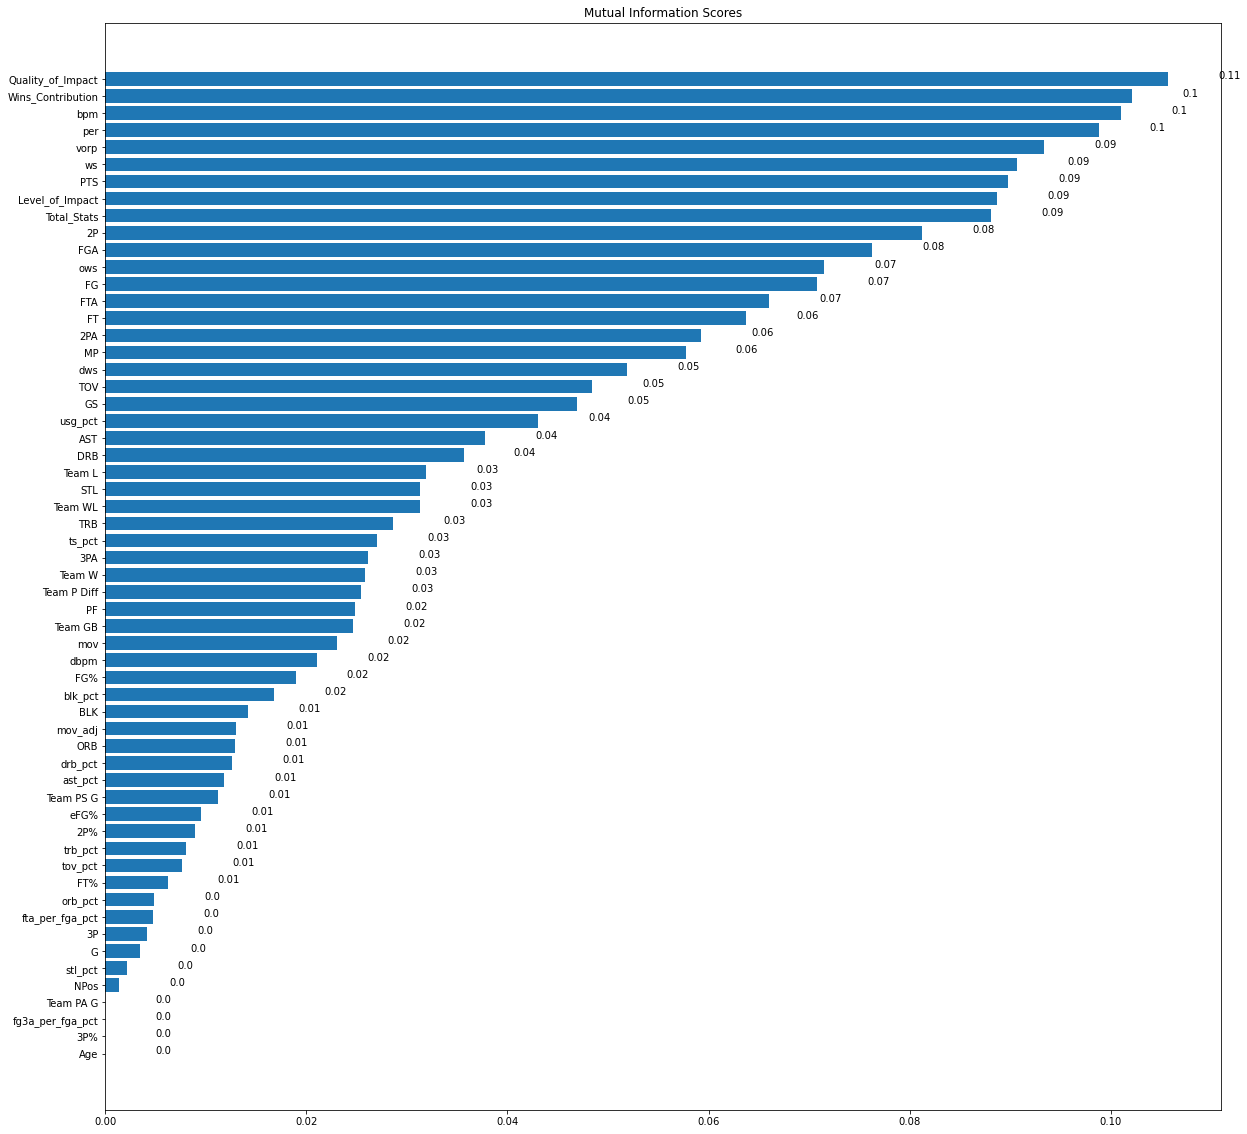

In [79]:
X, y, mi_scores = calculate_ml_scores(df=master_table_mi_2005)
plot_mi_scores(mi_scores, figsize=(20,20))

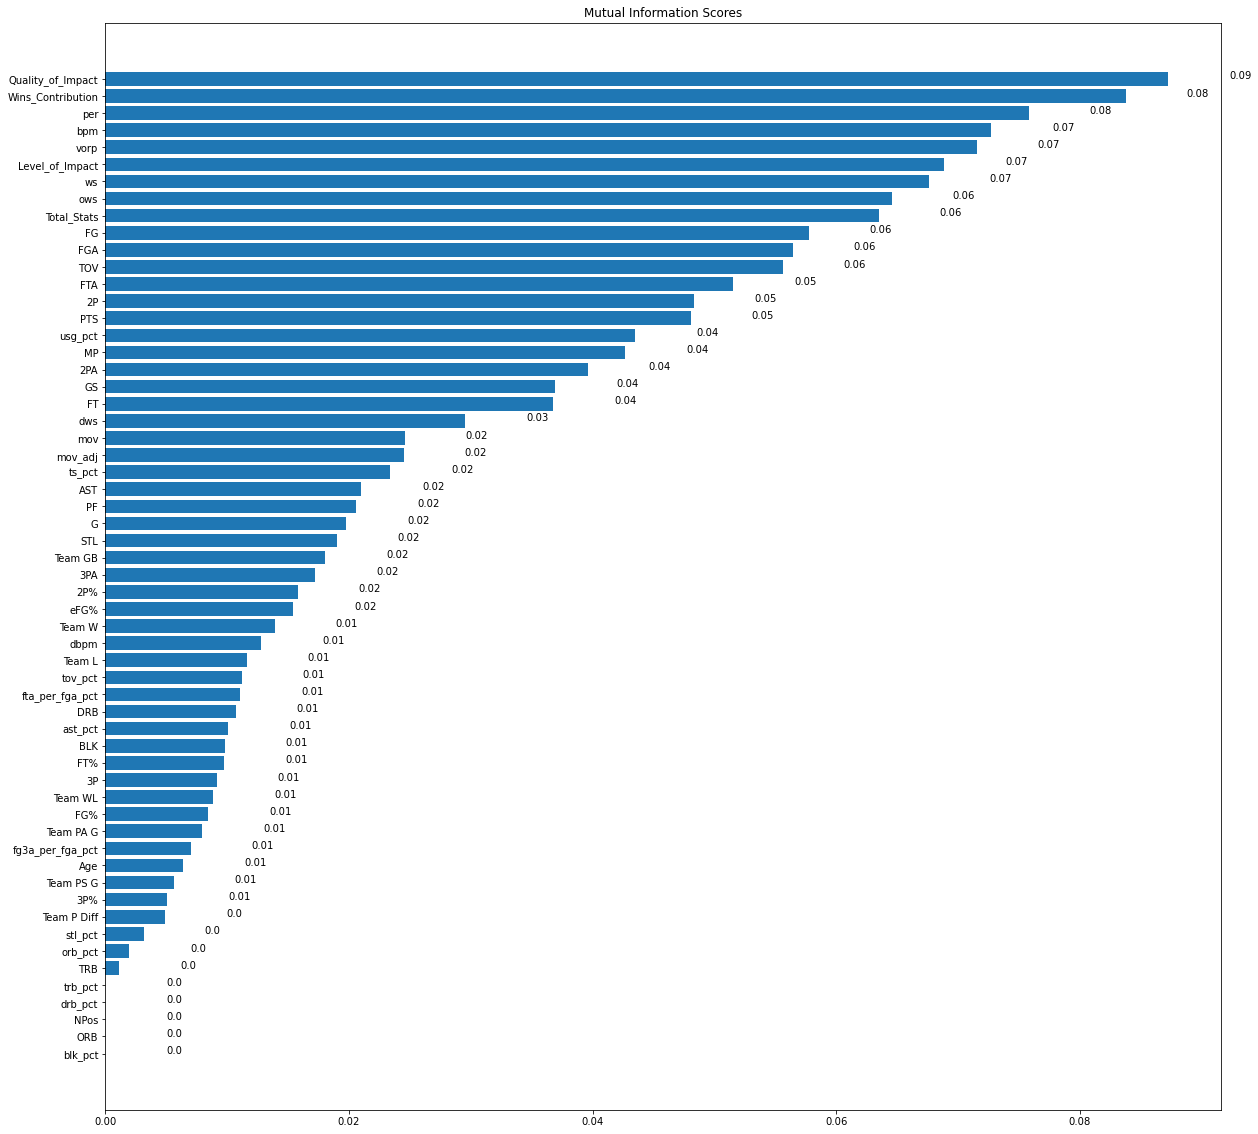

In [80]:
X, y, mi_scores = calculate_ml_scores(df=master_table_mi_2022)
plot_mi_scores(mi_scores, figsize=(20,20))

In [67]:
predictors5 = ["Wins_Contribution","vorp","Quality_of_Impact","bpm","ows","per","Level_of_Impact","PTS","Total_Stats","ws"]

In [68]:
mean_ap_ridge_5, aps_ridge_5, all_predictions_ridge_5 = backtest(stats_2005, reg, years_2005[5:], predictors4)
mean_ap_rf_5, aps_rf_5, all_predictions_rf_5 = backtest(stats_2005, rf2, years_2005[5:], predictors4)
mean_ap_lr_5, aps_lr_5, all_predictions_lr_5 = backtest(stats_2005, lr, years_2005[5:], predictors4)

In [69]:
mean_ap_ridge_6, aps_ridge_6, all_predictions_ridge_6 = backtest(stats_2022, reg, years_2022[5:], predictors5)
mean_ap_rf_6, aps_rf_6, all_predictions_rf_6 = backtest(stats_2022, rf2, years_2022[5:], predictors5)
mean_ap_lr_6, aps_lr_6, all_predictions_lr_6 = backtest(stats_2022, lr, years_2022[5:], predictors5)

In [70]:
mean_ap_ridge_5,mean_ap_rf_5,mean_ap_lr_5

(0.7720433364864117, 0.7895959124390496, 0.7720433364864117)

In [71]:
mean_ap_ridge_6,mean_ap_rf_6,mean_ap_lr_6

(0.8483796296296297, 0.833093156843157, 0.8483796296296297)

In [72]:
mean_squared_error(all_predictions_ridge_4["Share pc"], all_predictions_ridge_4["predictions1"]),mean_squared_error(all_predictions_rf_4["Share pc"], all_predictions_rf_4["predictions1"])

(0.0015987030251455386, 0.0010682782289494624)

In [73]:
mean_absolute_error(all_predictions_ridge_4["Share pc"], all_predictions_ridge_4["predictions1"]),mean_absolute_error(all_predictions_rf_4["Share pc"], all_predictions_rf_4["predictions1"])

(0.015553522674338807, 0.004042141207317859)

In [74]:
mean_absolute_error(all_predictions_ridge_5["Share pc"], all_predictions_ridge_5["predictions1"]),mean_absolute_error(all_predictions_rf_5["Share pc"], all_predictions_rf_5["predictions1"]),mean_absolute_error(all_predictions_lr_5["Share pc"], all_predictions_lr_5["predictions1"])

(0.017507841485277655, 0.0040457192307833114, 0.017510657329274915)

In [75]:
mean_absolute_error(all_predictions_ridge_6["Share pc"], all_predictions_ridge_6["predictions1"]),mean_absolute_error(all_predictions_rf_6["Share pc"], all_predictions_rf_6["predictions1"]),mean_absolute_error(all_predictions_lr_6["Share pc"], all_predictions_lr_6["predictions1"])

(0.014918102655803131, 0.003403656000321948, 0.01492030387127354)

In [76]:
mean_squared_error(all_predictions_ridge_5["Share pc"], all_predictions_ridge_5["predictions1"]),mean_squared_error(all_predictions_rf_5["Share pc"], all_predictions_rf_5["predictions1"]),mean_squared_error(all_predictions_lr_5["Share pc"], all_predictions_lr_5["predictions1"])

(0.0016192593172040023, 0.0011247561138759414, 0.0016192714444493836)

In [77]:
mean_squared_error(all_predictions_ridge_6["Share pc"], all_predictions_ridge_6["predictions1"]),mean_squared_error(all_predictions_rf_6["Share pc"], all_predictions_rf_6["predictions1"]),mean_squared_error(all_predictions_lr_6["Share pc"], all_predictions_lr_6["predictions1"])

(0.0015688119736823349, 0.0009117179693387654, 0.0015689018299482602)

In [78]:
all_predictions_ridge_4.to_csv("all_predictions_ridge_4.csv")
all_predictions_rf_4.to_csv("all_predictions_rf_4.csv")
all_predictions_ridge_5.to_csv("all_predictions_ridge_5.csv")
all_predictions_rf_5.to_csv("all_predictions_rf_5.csv")
all_predictions_lr_5.to_csv("all_predictions_lr_5.csv")
all_predictions_ridge_6.to_csv("all_predictions_ridge_6.csv")
all_predictions_rf_6.to_csv("all_predictions_rf_6.csv")
all_predictions_lr_6.to_csv("all_predictions_lr_6.csv")

In [79]:
all_predictions_ridge_6


,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
12785,Derrick Rose,0.977,2011,0.327065,2,1,-1
12193,Dwight Howard,0.531,2011,0.223999,5,2,-3
13614,LeBron James,0.431,2011,0.391127,1,3,2
7023,Kobe Bryant,0.354,2011,0.222815,6,4,-2
13133,Kevin Durant,0.157,2011,0.225580,4,5,1
...,...,...,...,...,...,...,...
2355,Ahmad Caver,0.000,2022,0.006423,209,601,392
10483,KZ Okpala,0.000,2022,0.006416,210,602,392
12280,Collin Sexton,0.000,2022,0.006407,211,603,392


In [1]:
stats.columns

NameError: name 'stats' is not defined